# INCEPTION SCORE

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from icecream import ic


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim

from PIL import Image
import pandas as pd

from scipy.stats import entropy

from torch import nn, optim

from torchmetrics.image.inception import InceptionScore


## CGAN 64x64
- 15 epoci
- 30 epoci

In [50]:
## MODELS ##
from Models.CGAN_64x64.dataset import DatasetCelebA
from Models.CGAN_64x64.discriminator_test import Discriminator
from Models.CGAN_64x64.generator_test import Generator

def generate_images(base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci', 
                    attribut=0, img_size=64, display=0, numberOfSamples = 1):
# Dimensiunea vectorului latent
    dim_zgomot = 100

    retea_G = Generator(dim_zgomot=dim_zgomot, img_size=img_size)
    retea_D = Discriminator(img_size=img_size)


    retea_G.load_state_dict(torch.load(base_path + '\\retea_Generator.pt'))
    retea_D.load_state_dict(torch.load(base_path + '\\retea_Discriminator.pt'))

    # retea_G.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\ConditionalGAN_onlyGender\\10epoci\\retea_Generator.pt'))
    # retea_D.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\ConditionalGAN_onlyGender\\10epoci\\retea_Discriminator.pt'))

    retea_G.cuda()
    retea_D.cuda()

    retea_G.eval()
    retea_D.eval()
    # esantioane_proba = torch.randn(1, dim_zgomot, 1, 1)
    # etichete_proba = torch.LongTensor([0])
    if numberOfSamples > 1:
        esantioane_proba = torch.randn(numberOfSamples, dim_zgomot, 1, 1)
        etichete_proba1 = torch.FloatTensor([[attribut]])
        etichete_proba = etichete_proba1.repeat(numberOfSamples, 1)
    else:
        esantioane_proba = torch.randn(numberOfSamples, dim_zgomot, 1, 1)
        etichete_proba = torch.FloatTensor([[attribut]])

    etichete_proba = etichete_proba.to(torch.device('cuda'))
    esantioane_proba = esantioane_proba.to(torch.device('cuda'))

    imagini_generate = retea_G(esantioane_proba, etichete_proba).detach()
    imagini_generate = torch.squeeze(imagini_generate, 0)
    imagini_generate = imagini_generate.to(torch.device('cpu'))

    if numberOfSamples > 1:
        return imagini_generate
    
    # plt.figure()
    # plt.title("Imagini generate")
    # plt.imshow(np.transpose(imagini_generate,(1,2,0)))
    # plt.show()
    if display == 1:
        plt.figure()
        plt.imshow(np.transpose(imagini_generate,(1,2,0)))
        plt.show()

    return np.transpose(imagini_generate,(1,2,0))


# generate_images(display=0, numberOfSamples=2)


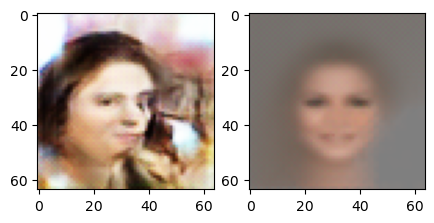

In [71]:
path1='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci'
path2='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\40epoci'

img_1 = generate_images(base_path=path1, attribut=0)
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img_1)
img_2 = generate_images(base_path=path2, attribut=0)
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.show()

# img_1 = np.transpose(img_1,(2,1,0))
# img_2 = np.transpose(img_2,(2,1,0))

# generated_images = torch.stack([img_1, img_2], dim=0)
inception = InceptionScore(normalize=True)

# inception.update(generated_images)
# score, std = inception.compute()
# print(f"Inception score: {score}")

# generated_images = torch.stack([img_1, img_2], dim=0)
# print(generated_images.shape)

# # Calculate the Inception Score
# score = inception_score(generated_images, device)
# print("Inception Score:", score)

In [69]:
path1='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\15epoci'
path2='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\CGAN_64x64\\40epoci'

images1 = generate_images(base_path=path1, attribut=1, numberOfSamples=15)
images2 = generate_images(base_path=path2, attribut=1, numberOfSamples=15)

# ic(more_images.shape)
inception = InceptionScore(normalize=True)

inception.update(images1)
score, std = inception.compute()
print(f"Inception score: {score}")

inception = InceptionScore(normalize=True)
inception.update(images2)
score, std = inception.compute()
print(f"Inception score: {score}")



Inception score: 1.228780746459961
Inception score: 1.0034589767456055


In [74]:
from torchmetrics.image.fid import FrechetInceptionDistance
EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"

fid = FrechetInceptionDistance(feature=64, normalize=True)
synth_images = generate_images(base_path=path2, attribut=0, numberOfSamples=2)
# images2 = generate_images(base_path=path2, attribut=1, numberOfSamples=15)

dataset = DatasetCelebA(base_path=DATASET_PATH, excel_path=EXCEL_PATH)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

image, label = dataset[0]
image2, label2 = dataset[7]
real_images = torch.stack([image, image2], dim=0)


fid.update(real_images, real=True)
fid.update(synth_images, real=False)
fid.compute()

tensor(6.2592)

# A2F
- 64x64

In [ ]:
## MODELS ##
from Models.A2F_64x64.dataset import  DatasetCelebA_Sketch
from Models.A2F_64x64.Discriminator_Stage2 import Discriminator as Discriminator_S2
from Models.A2F_64x64.Generator_Stage2 import Generator as Generator_S2
from Models.A2F_64x64.Discriminator_Stage3 import Discriminator as Discriminator_S3
from Models.A2F_64x64.Generator_Stage3 import Generator as Generator_S3
from Models.A2F_64x64.CVAE_Encoder import Encoder
from Models.A2F_64x64.CVAE_Decoder import Decoder
DEVICE = 'cuda'

def init_models(base_path, attribute_dim=4, img_size=64):
    encoder = Encoder(attribute_number=attribute_dim)
    decoder = Decoder(attribute_number=attribute_dim)
    retea_G3 = Generator_S3(img_size=3, attribute_number=attribute_dim)
    retea_D3 = Discriminator_S3(img_size=img_size, attribute_number=attribute_dim)
    retea_G2 = Generator_S2(attribute_number=attribute_dim)
    retea_D2 = Discriminator_S2(img_size=img_size, attribute_number=attribute_dim)
    retea_G3.cuda()
    retea_D3.cuda()
    retea_G2.cuda()
    retea_D2.cuda()
    encoder.cuda()
    decoder.cuda()
    encoder.eval()
    decoder.eval()
    retea_G3.eval()
    retea_D3.eval()
    retea_G2.eval()
    retea_D2.eval()

    decoder.load_state_dict(torch.load(base_path + '\\retea_Decoder.pt'))
    encoder.load_state_dict(torch.load(base_path + '\\retea_Encoder.pt'))

    retea_D2.load_state_dict(torch.load(base_path + '\\retea_D_Stage2.pt'))
    retea_G2.load_state_dict(torch.load(base_path + '\\retea_G_Stage2.pt'))

    retea_D3.load_state_dict(torch.load(base_path + '\\A2F_retea_D_Stage3.pt'))
    retea_G3.load_state_dict(torch.load(base_path + '\\A2F_retea_G_Stage3.pt'))
    return encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3

base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\A2F_64x64'
encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3 = init_models(base_path=base_path)
def synth_images(base_path='E:\Lucru\Dizertatie\Cod\EvaluatingPerformance\Pretrained\A2F_64x64', attribut=[0,0,0,1], img_size=64, display=0, stage=3):
    # encoder, decoder, retea_D2, retea_G2, retea_D3, retea_G3 = init_models(base_path=base_path)
        
    sketch_img = torch.randn(3, img_size, img_size)
    esantioane_proba = torch.stack([sketch_img], dim=0)
    attributes = torch.FloatTensor([attribut])

    esantioane_proba = esantioane_proba.to(torch.device(DEVICE))
    attributes = attributes.to(torch.device(DEVICE))
    zgomot_proba = torch.FloatTensor(esantioane_proba.shape[0], 256).normal_(0, 1)
    zgomot_proba  = zgomot_proba.to(torch.device(DEVICE))

    zgomot_embedded, schita_embedded, encode_text = encoder(noise=zgomot_proba, attr_text=attributes, sketch=esantioane_proba, detach_flag=True)
    reconstructed_sketch_images, reconstructed_fake_images = decoder(zgomot_embedded[0], schita_embedded[0], detach_flag=True)

    imagini_generate_Stage2 = retea_G2(reconstructed_fake_images, encode_text).detach()
    imagini_generate_Stage3 = retea_G3(imagini_generate_Stage2, attributes).detach()


    reconstructed_sketch_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_sketch_images = reconstructed_sketch_images.to(torch.device('cpu'))

    reconstructed_fake_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_fake_images = reconstructed_fake_images.to(torch.device('cpu'))

    imagini_generate_Stage2 = torch.squeeze(imagini_generate_Stage2, 0)
    imagini_generate_Stage2 = imagini_generate_Stage2.to(torch.device('cpu'))

    imagini_generate_Stage3 = torch.squeeze(imagini_generate_Stage3, 0)
    imagini_generate_Stage3 = imagini_generate_Stage3.to(torch.device('cpu'))


    if display == 1 :
        plt.figure(figsize=(10,15))
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa1")
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa2")
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Etapa3")
        plt.show()
    
    if stage==3:
        return np.transpose(imagini_generate_Stage3,(1,2,0))
    
    if stage==2:
        return np.transpose(imagini_generate_Stage2,(1,2,0))
    
    if stage==1:
        return np.transpose(reconstructed_fake_images,(1,2,0))

a = synth_images(attribut=[0,0,0,1] ,display=1)

In [ ]:
img_1 = synth_images(attribut=[0,0,0,1] ,display=0,stage=1)
img_2 = synth_images(attribut=[0,0,0,1] ,display=0,stage=1)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img_1)
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.show()

img_1 = img_1.numpy()
img_2 = img_2.numpy()
# Convert the images to grayscale if necessary
if img_1.ndim == 3:
    img_1 = img_1.mean(axis=2)
if img_2.ndim == 3:
    img_2 = img_2.mean(axis=2)

ssim_value = ssim(img_1, img_2, data_range=img_2.max() - img_2.min())

print("SSIM:", ssim_value)

In [ ]:

def make_gray(img):
    img = img.numpy()
    if img.ndim == 3:
        img = img.mean(axis=2)
    return img

def ssim_mean(attr, number_of_samples=100, stage=3):
    ssim_sum = 0
    for i in range(0,number_of_samples):
        img_1 = synth_images(attribut=attr,stage=stage)
        img_2 = synth_images(attribut=attr,stage=stage)
        img_1 = make_gray(img_1)
        img_2 = make_gray(img_2)
        ssim_value = ssim(img_1, img_2, data_range=img_2.max() - img_2.min())
        ssim_sum += ssim_value

    ssim_mean = ssim_sum / number_of_samples
    print(f"Media SSIM: {ssim_mean}")
    return ssim_mean


ssim_mean1 = ssim_mean(attr=[1,0,0,1],stage=1)
ssim_mean1 = ssim_mean(attr=[1,0,0,1],stage=2)
ssim_mean1 = ssim_mean(attr=[1,0,0,1],stage=3)
